In [1]:
from aquaculture import *
from deepSolver import *
from fdSolver import *
from jointOptCtrlStopping import *
from deepOS import *

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import hashlib
pltStyles = ['seaborn-v0_8-paper', 'dark_background']
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [2]:
import IPython
ipython = IPython.get_ipython()
ipython.run_line_magic(magic_name="load_ext", line="autoreload")
ipython.run_line_magic(magic_name="autoreload", line="2") # automatically reload modules before executing user code

# Joint Stochastic Optimal Control and Stopping

## Aquaculture Model

In [3]:
T = 3.0 # time horizon
r = 0.01 # interest rate

# Feeding Curve
f0 = 0.1
F = LinearFeeding(f0,T)
ft = F(np.linspace(0, T, 100))

# Host parameters
mu = 0.1
mu_F = 3.0
h0 = 1 # unit host size

hModel = HostConstant(mu, mu_F, F)

# Weight parameters
gamma = 5.0
gamma_F = 10.0
w_inf = 3.0
w0 = 0.01 
nu=0.75

wModel = GrowthConst(gamma, gamma_F, w_inf, F, nu=nu)

# Feed price parameters
sigmaF = 0.25
PF0 = 0.075

pFModel = FeedPriceGBM(r, sigmaF)
pFt = pFModel.simulate(np.linspace(0,T,100), PF0, batch=1024, seed=seed)
# Biomass price parameters
sigmaB = 0.1
PB0 = 0.1

pBModel = BiomassPriceGBM(r, sigmaB)
pBt = pBModel.simulate(np.linspace(0,T,100), PB0, batch=1024,seed=seed+1)

# Grids
N=64
Nt=2048

bnds = [(0.0, T, Nt), # time
        (0.5*w0, 1.1*w_inf, N), # weight
        (0.1*h0, 1.1*h0, N), # host
        (0.1*pFt.min(), 1.5*pFt.max(), N//2), # feed price
        (0.1*pBt.min(), 1.5*pBt.max(), N//2), # biomass price
        (0.0, ft.max(), N)] # control
del pFt, pBt, ft
labels = ["Weight", "Host", "Feed Price", "Biomass Price", "Control", "Value"]
id = hashlib.md5(repr((
    [T,r,f0,mu,mu_F,h0,gamma,gamma_F,w_inf,nu,sigmaF,sigmaB]+
    [np.round(x,9) for b in bnds for x in b]+
    [str(m.__class__.__name__) for m in [pFModel, pBModel, hModel, wModel]]
)).encode('utf-8')).hexdigest()

figureSaveDirectory = "../Figures/Aquaculture/"+ str(id) + "/"
fileSaveDirectory = "../Data/Aquaculture/"+ str(id) + "/"
Path(figureSaveDirectory).mkdir(parents=True, exist_ok=True)
Path(fileSaveDirectory).mkdir(parents=True, exist_ok=True)
print(bnds)
print("ID: ", id)

[(0.0, 3.0, 2048), (0.005, 3.3000000000000003, 64), (0.1, 1.1, 64), (0.0019001390573845957, 0.38557792417055026, 32), (0.005509022419834892, 0.2635373343778614, 32), (0.0, 0.9999999999999999, 64)]
ID:  332e7e3f6e9e54a81fe635fd8c8e875e


In [4]:
df=params_to_df([hModel, wModel, pFModel, pBModel,F],initialDatum={"h_0":h0,"w_0":w0,"p^F_0":PF0,"p^B_0":PB0},float_format=".3f").T
df.to_csv(fileSaveDirectory+"params.csv", header=False)
print(df.to_latex(header=False, escape=False))

\begin{tabular}{ll}
\toprule
$h_0$          &        $1.000$ \\
$w_0$          &        $0.010$ \\
$p^F_0$        &        $0.075$ \\
$p^B_0$        &        $0.100$ \\
$\mu_0$        &        $0.100$ \\
$\mu_F$        &        $3.000$ \\
$F$            &  LinearFeeding \\
$\gamma_0$     &        $5.000$ \\
$\gamma_F$     &       $10.000$ \\
$w_{\infty}$   &        $3.000$ \\
$\nu$          &        $0.750$ \\
$r$            &        $0.010$ \\
$\sigma^{p^F}$ &        $0.250$ \\
$\sigma^{p^B}$ &        $0.100$ \\
$f_0$          &        $0.100$ \\
$T$            &        $3.000$ \\
$\eta$         &        $0.300$ \\
\bottomrule
\end{tabular}



C:\Users\kevin\AppData\Local\Temp\ipykernel_9092\2223737211.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(header=False, escape=False))


## Benchmark


In [5]:
k = lambda t, w, h, pf, pb, u: - h * u * pf
g = lambda t, w, h, pf, pb: w * h * pb
processes = [wModel, hModel, pFModel, pBModel]
d = len(processes)
M = 1024*8

t = torch.linspace(0, T, Nt, dtype=dtype, device=device).reshape(1,-1)
dWt = BrownianMotion(t, M, dim=d, onlyIncrements=True, dtype=dtype, device=device)

benchmark = JointOptCtrlStopping(r, k, g, bnds, processes, CtrlStoppingSolver, {}, device=device, dtype=dtype)
U0 = lambda x: torch.zeros((x.shape[0],1), dtype=dtype, device=device)
Uft = lambda x: F(x[:,0]).reshape(-1,1)
wt = wModel.simulate(t, w0, Uft).detach().cpu()
ht = hModel.simulate(t, h0, Uft).detach().cpu()
tauInd_determ = torch.argmax(wt*ht,axis=1)
tau_determ = t.detach().cpu()[:,tauInd_determ]

In [6]:
# for i, style in enumerate(pltStyles):
#     with plt.style.context(style):
#         fig_wtUft = wModel.plot(t, wt, title="Weight over time", xlabel="Time", ylabel="Weight", wi=[0])
#         fig_wtUft.savefig(figureSaveDirectory + "wtUft_" + style + ".pdf")
#     if i==len(pltStyles)-1:
#         plt.show()
#     else:
#         plt.close()
# for i, style in enumerate(pltStyles):
#     with plt.style.context(style):
#         fig_htUft = wModel.plot(t, ht, title="Hosts over time", xlabel="Time", ylabel="Hosts", wi=[0])
#         fig_htUft.savefig(figureSaveDirectory + "htUft_" + style + ".pdf")
#     if i==len(pltStyles)-1:
#         plt.show()
#     else:
#         plt.close()

Benchmark (u=0):  0.000968505279161036
Benchmark (u=0) stopped at ( 2.1763556003570557 ):  0.02850445918738842
Benchmark (u=0) opt stopped at ( 1.533646583557129 ): with price 0.05639927461743355


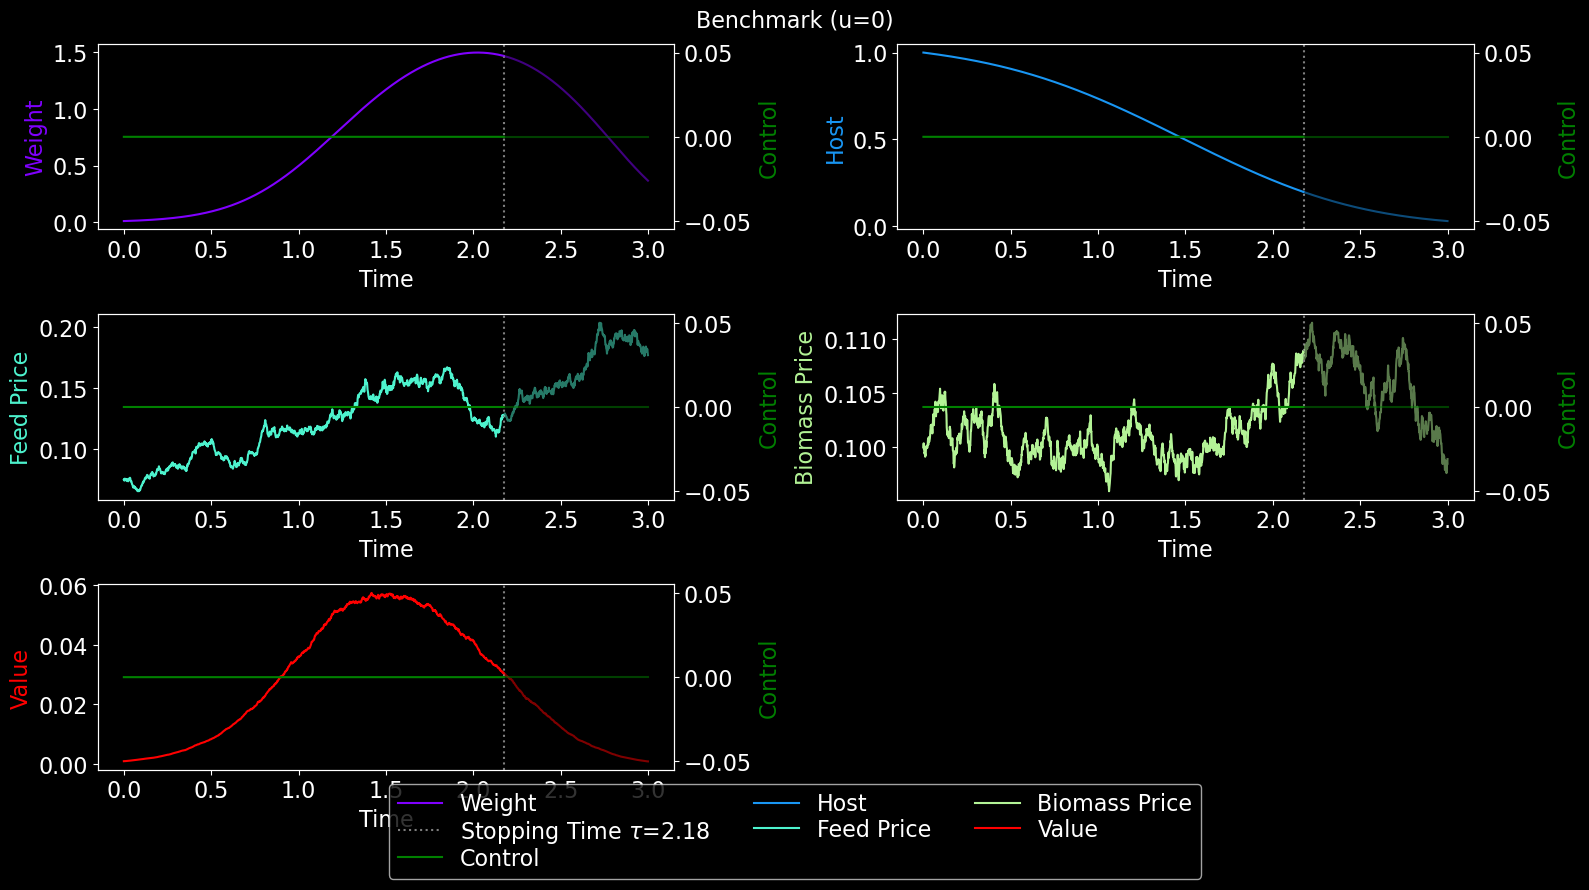

In [7]:
if Path(fileSaveDirectory + "b0.npy").is_file():
    bench_0 = torch.from_numpy(np.load(fileSaveDirectory + "b0.npy")).to(dtype=dtype, device='cpu')
else:
    bench_0, _, _ = benchmark.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, U=U0)
    np.save(fileSaveDirectory + "b0.npy", bench_0.cpu().numpy())

if not Path(fileSaveDirectory + "b0tau.npy").is_file():
    N_os:int = int(T*128) # number of time steps, don't use too many, it will slow down the method a lot
    t_os:torch.Tensor = torch.linspace(0.0,T,N_os,dtype=dtype,device=device)

    def trainGen(M,batch_factor=64): # You can change this and still use the same DeepOS network!
        while True:
            dWt = BrownianMotion(t_os, M * batch_factor, dim=d, onlyIncrements=True, dtype=dtype, device=device)
            data = benchmark.simulate(t_os, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, U=U0)[0]
            for i in range(batch_factor):
                yield data[i*M:(i+1)*M,...]

    latent_dim: List[int] = [d+50,d+50] # latent dimensions of neural network
    dOS = DeepOSNet(d+1,N_os,latent_dim=latent_dim,outputDims=1).to(device)
    # print(dOS.deepOSNet)
    trainErr, trainPrice=dOS.train_loop(trainGen)


    #########################################################################
    ### Testing
    #########################################################################
    test = next(trainGen(M,batch_factor=1))
    tau,payoff=dOS.evalStopping(t_os,test)

    b0tau=np.array([tau.mean().item(),payoff.mean().item()])
    np.save(fileSaveDirectory+"b0tau.npy", b0tau)
    del dOS
else: 
    b0tau = np.load(fileSaveDirectory+"b0tau.npy")
    
print("Benchmark (u=0): ", torch.mean(bench_0[:,-1,-1]).item())
print("Benchmark (u=0) stopped at (", tau_determ.item(), "): ", torch.mean(bench_0[:,tauInd_determ,-1]).item())
print(f'Benchmark (u=0) opt stopped at ( {b0tau[0]} ): with price {b0tau[1]}')

for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_b0 = plotMethod(t, bench_0, tau_determ*torch.ones((M,1),dtype=dtype,device='cpu'), tauInd_determ*torch.ones((M,1),dtype=torch.int32,device='cpu'), wi=[0], labels=labels,title="Benchmark (u=0)")
        fig_b0.savefig(figureSaveDirectory + "b0_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()


Benchmark (u=F):  0.1175394207239151
Benchmark (u=F) stopped at ( 2.1763556003570557 ):  0.1731678992509842
Benchmark (u=F) opt stopped at ( 1.9467850923538208 ): with price 0.17980283498764038


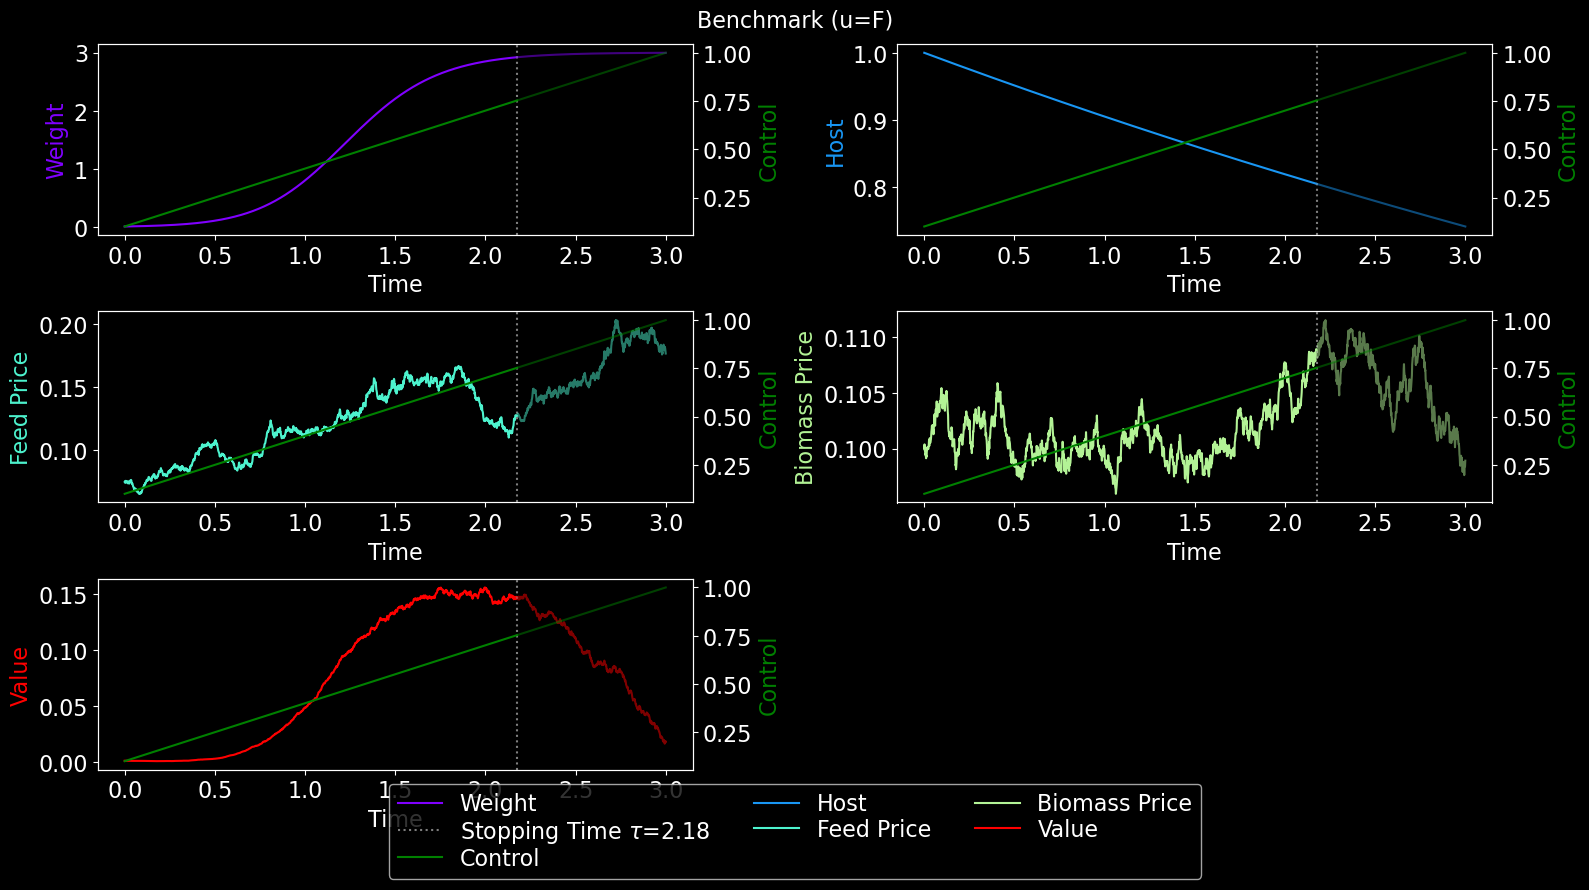

In [8]:
if Path(fileSaveDirectory + "bft.npy").is_file():
    bench_ft = torch.from_numpy(np.load(fileSaveDirectory + "bft.npy")).to(dtype=dtype, device='cpu')
else:
    bench_ft, _, _ = benchmark.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, U=Uft)
    np.save(fileSaveDirectory + "bft.npy", bench_ft.cpu().numpy())

if not Path(fileSaveDirectory + "bfttau.npy").is_file():
    N_os:int = int(T*128) # number of time steps, don't use too many, it will slow down the method a lot
    t_os:torch.Tensor = torch.linspace(0.0,T,N_os,dtype=dtype,device=device)

    def trainGen(M,batch_factor=64): # You can change this and still use the same DeepOS network!
        while True:
            dWt = BrownianMotion(t_os, M * batch_factor, dim=d, onlyIncrements=True, dtype=dtype, device=device)
            data = benchmark.simulate(t_os, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, U=Uft)[0]
            for i in range(batch_factor):
                yield data[i*M:(i+1)*M,...]

    latent_dim: List[int] = [d+50,d+50] 
    dOS = DeepOSNet(d+1,N_os,latent_dim=latent_dim,outputDims=1).to(device) #d+1 because control is included
    trainErr, trainPrice=dOS.train_loop(trainGen)
    test = next(trainGen(M,batch_factor=1))
    tau,payoff=dOS.evalStopping(t_os,test)
    bfttau=np.array([tau.mean().item(),payoff.mean().item()])
    np.save(fileSaveDirectory+"bfttau.npy", bfttau)
    del dOS
else:
    bfttau = np.load(fileSaveDirectory+"bfttau.npy")
print("Benchmark (u=F): ", torch.mean(bench_ft[:,-1,-1]).item())
print("Benchmark (u=F) stopped at (", tau_determ.item(), "): ", torch.mean(bench_ft[:,tauInd_determ,-1]).item())
print(f'Benchmark (u=F) opt stopped at ( {bfttau[0]} ): with price {bfttau[1]}')
for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_bft = plotMethod(t, bench_ft, tau_determ*torch.ones((M,1),dtype=dtype,device='cpu'), tauInd_determ*torch.ones((M,1),dtype=torch.int32,device='cpu'), wi=[0], labels=labels,title="Benchmark (u=F)")
        fig_bft.savefig(figureSaveDirectory + "bft_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

In [9]:
del benchmark

## Finite-Difference Solver

In [10]:
tIndSave = torch.arange(0, Nt, 1, dtype=torch.int32, device=device)[::4]
tIndSave[-1] = Nt-1
fdSolverArgs = {'tIndSave': tIndSave}

FD Solver (u=u^*) stopped at ( 1.965216875076294 ):  0.18405108153820038


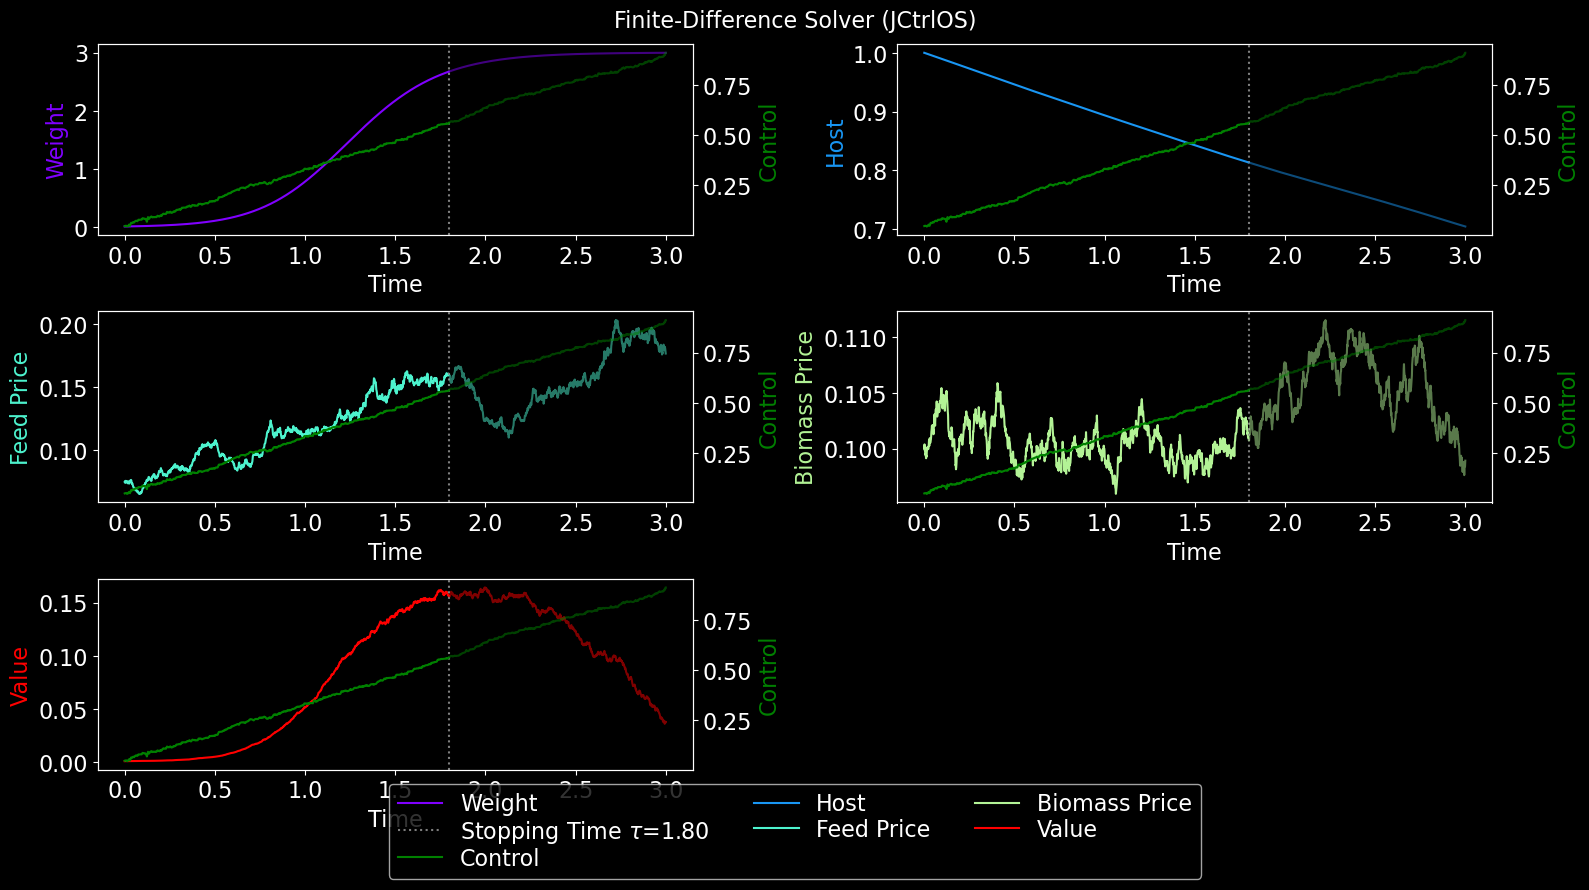

In [11]:
# %%script echo skipping # Disable cell execution
if Path(fileSaveDirectory + "fd1.npy").is_file():
    fd1 = torch.from_numpy(np.load(fileSaveDirectory + "fd1.npy")).to(dtype=dtype, device='cpu')
    tau_fd1 = torch.from_numpy(np.load(fileSaveDirectory + "tau_fd1.npy")).to(dtype=dtype, device='cpu')
    tauInd_fd1 = torch.from_numpy(np.load(fileSaveDirectory + "tauInd_fd1.npy")).to(dtype=torch.int64, device='cpu')
else:
    fdOpt1 = JointOptCtrlStopping(r, k, g, bnds, processes, FDSolver, fdSolverArgs, device=device, dtype=dtype)
    fdOpt1.solve(stopping=True)
    fd1, tau_fd1, tauInd_fd1 = fdOpt1.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)
    np.save(fileSaveDirectory + "fd1.npy", fd1.cpu().numpy())
    np.save(fileSaveDirectory + "tau_fd1.npy", tau_fd1.cpu().numpy())
    np.save(fileSaveDirectory + "tauInd_fd1.npy", tauInd_fd1.cpu().numpy())
    del fdOpt1

print("FD Solver (u=u^*) stopped at (", tau_fd1.mean().item(), "): ", torch.mean(torch.take_along_dim(fd1[:,:,-1], tauInd_fd1.unsqueeze(-1), dim=1)).item())
for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_fd1 = plotMethod(t, fd1, tau_fd1, tauInd_fd1, wi=[0], labels=labels,title="Finite-Difference Solver (JCtrlOS)")
        fig_fd1.savefig(figureSaveDirectory + "fd1_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

FD Solver (u=û):  0.12591767311096191
FD Solver (u=û, tau=const):  0.17608006298542023
Benchmark (u=û) opt stopped at ( 1.9611618518829346 ): with price 0.179297536611557


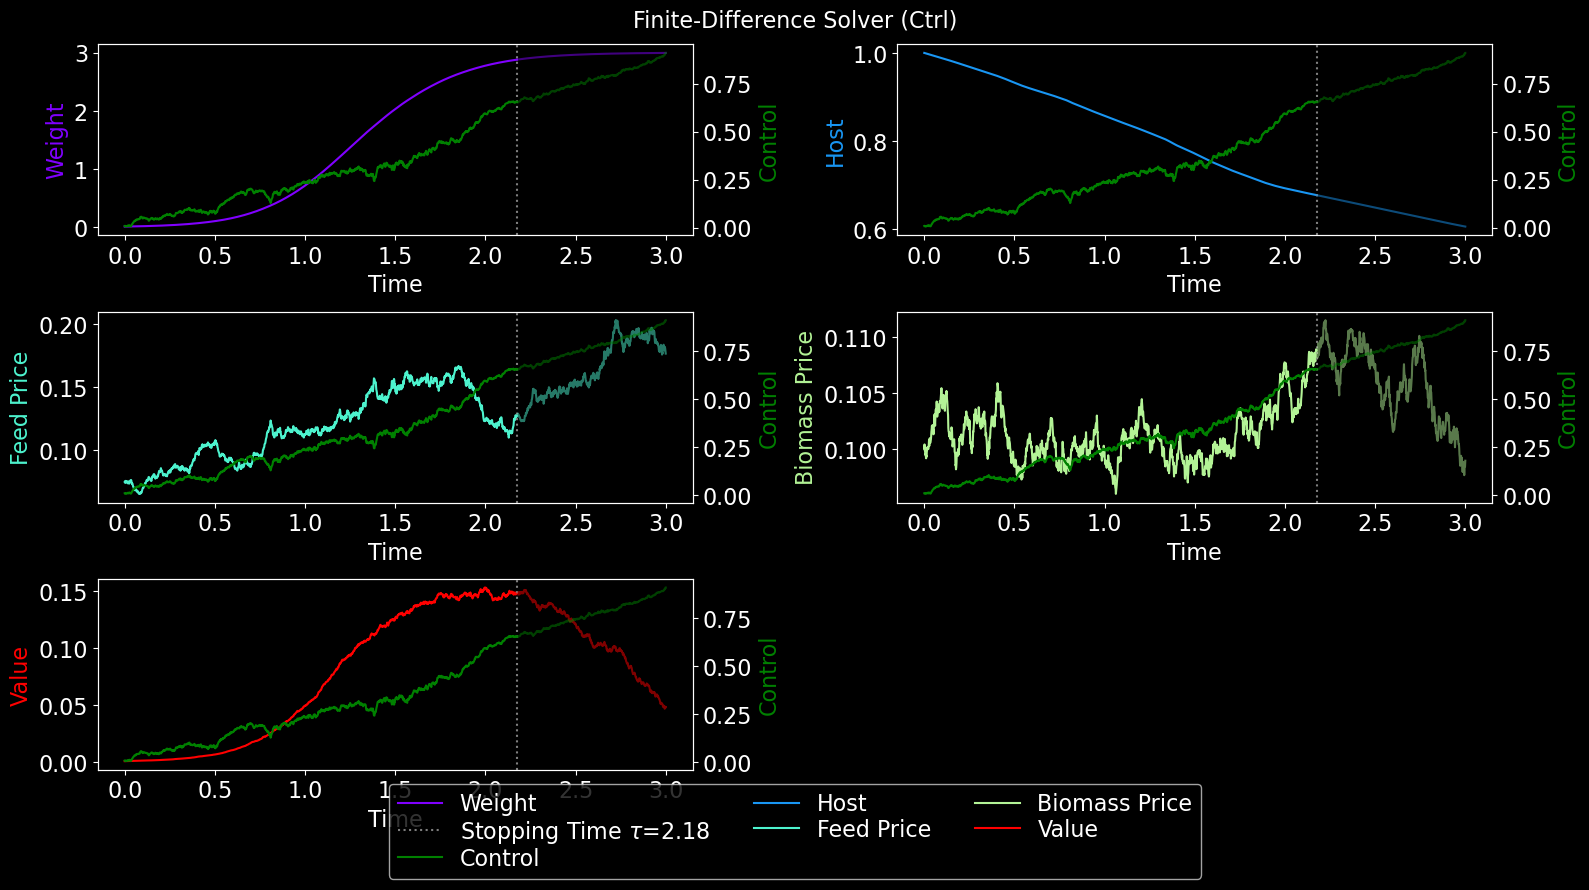

In [12]:
# %%script echo skipping # Disable cell execution
if Path(fileSaveDirectory + "fd2.npy").is_file():
    fd2 = torch.from_numpy(np.load(fileSaveDirectory + "fd2.npy")).to(dtype=dtype, device='cpu')
    tau_fd2 = torch.from_numpy(np.load(fileSaveDirectory+"tau_fd2.npy")).to(dtype=dtype, device='cpu')
    payoff_fd2 = torch.from_numpy(np.load(fileSaveDirectory+"payoff_fd2.npy")).to(dtype=dtype, device='cpu')
    tauInd_fd2 = torch.from_numpy(np.load(fileSaveDirectory+"tauInd_fd2.npy")).to(dtype=torch.int32, device='cpu')
else:
    fdOpt2 = JointOptCtrlStopping(r, k, g, bnds, processes, FDSolver, fdSolverArgs, device=device, dtype=dtype)
    fdOpt2.solve(stopping=False)
    fd2, _, _ = fdOpt2.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)
    np.save(fileSaveDirectory + "fd2.npy", fd2.cpu().numpy())

    N_os:int = int(T*128) # number of time steps, don't use too many, it will slow down the method a lot
    t_os:torch.Tensor = torch.linspace(0.0,T,N_os,dtype=dtype,device='cpu')

    fdOpt2.V = None
    def trainGen(M,batch_factor=4): # You can change this and still use the same DeepOS network!
        while True:
            dWt = BrownianMotion(t_os, M * batch_factor, dim=d, onlyIncrements=True, dtype=dtype, device='cpu')
            data = fdOpt2.simulate(t_os, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device='cpu'), dWt)[0]
            for i in range(batch_factor):
                yield data[i*M:(i+1)*M,...].to(device)

    latent_dim: List[int] = [d+50,d+50] 
    dOS = DeepOSNet(d+1,N_os,latent_dim=latent_dim,outputDims=1).to(device) #d+1 because control is included
    trainErr, trainPrice=dOS.train_loop(trainGen)
    indOS = torch.argmin(torch.abs(t_os.view(-1,1) - t.cpu().view(1,-1)), dim=1)
    tau_fd2,payoff_fd2=dOS.evalStopping(t[:,indOS],fd2[:,indOS,:])
    tauInd_fd2 = torch.min(torch.abs(t-tau_fd2), dim=1, keepdim=False)[1]
    np.save(fileSaveDirectory+"tau_fd2.npy", tau_fd2.cpu().numpy())
    np.save(fileSaveDirectory+"payoff_fd2.npy", payoff_fd2.cpu().numpy())
    np.save(fileSaveDirectory+"tauInd_fd2.npy", tauInd_fd2.cpu().numpy())
    del fdOpt2,dOS

print("FD Solver (u=û): ", torch.mean(fd2[:,-1,-1]).item())
print("FD Solver (u=û, tau=const): ", torch.mean(torch.take_along_dim(fd2[:,:,-1].cpu(), tauInd_determ.unsqueeze(-1), dim=1)).item())
print(f'Benchmark (u=û) opt stopped at ( {tau_fd2.mean().item()} ): with price {payoff_fd2.mean().item()}')
for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_fd2 = plotMethod(t, fd2, tau_determ*torch.ones((M,1),dtype=dtype,device='cpu'), tauInd_determ*torch.ones((M,1),dtype=torch.int32,device='cpu'), wi=[0], labels=labels,title="Finite-Difference Solver (Ctrl)")
        fig_fd2.savefig(figureSaveDirectory + "fd2_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

Backward time steps: 2047it [01:42, 20.03it/s]
100%|██████████| 1500/1500 [41:27<00:00,  1.66s/it, loss=-0.182, payoff=0.183, learning rate=[0.0005000000000000001]]


FD Solver (u=\tilde{u}):  0.17755506932735443
Benchmark (u=\tilde{u}) opt stopped at ( 1.9367942810058594 ): with price 0.18300455808639526


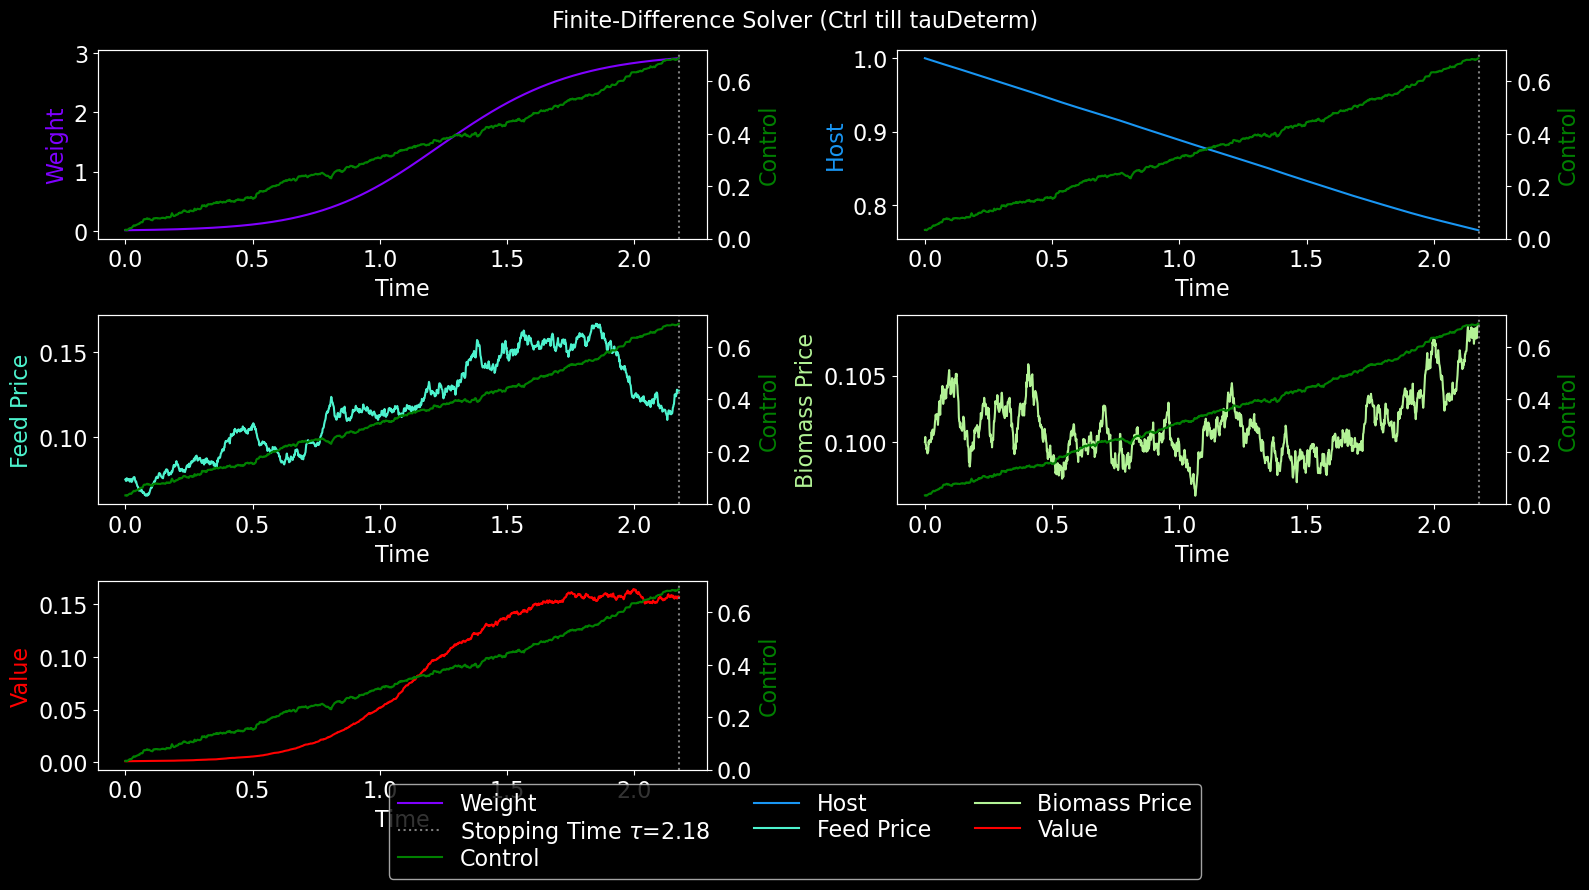

In [13]:
# %%script echo skipping # Disable cell execution
if Path(fileSaveDirectory + "fd3.npy").is_file():
    fd3 = torch.from_numpy(np.load(fileSaveDirectory + "fd3.npy")).to(dtype=dtype, device=device)
    tau_fd3 = torch.from_numpy(np.load(fileSaveDirectory+"tau_fd3.npy")).to(dtype=dtype, device=device)
    payoff_fd3 = torch.from_numpy(np.load(fileSaveDirectory+"payoff_fd3.npy")).to(dtype=dtype, device=device)
    tauInd_fd3 = torch.from_numpy(np.load(fileSaveDirectory+"tauInd_fd3.npy")).to(dtype=torch.int32, device=device)
else:
    bnds_copy = [(0, tau_determ.mean().item(), Nt)] + bnds[1:]
    fdOpt3 = JointOptCtrlStopping(r, k, g, bnds_copy, processes, FDSolver, fdSolverArgs, device=device, dtype=dtype)
    fdOpt3.solve(stopping=False)
    fd3, _, _ = fdOpt3.simulate(t[:,:tauInd_determ], torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt[:,:tauInd_determ])
    np.save(fileSaveDirectory + "fd3.npy", fd3.cpu().numpy())

    N_os:int = int(T*128) # number of time steps, don't use too many, it will slow down the method a lot
    t_os:torch.Tensor = torch.linspace(0.0,bnds_copy[0][-2],N_os,dtype=dtype,device='cpu')

    fdOpt3.V = None
    def trainGen(M,batch_factor=8): # You can change this and still use the same DeepOS network!
        while True:
            dWt = BrownianMotion(t_os, M * batch_factor, dim=d, onlyIncrements=True, dtype=dtype, device='cpu')
            data = fdOpt3.simulate(t_os, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device='cpu'), dWt)[0]
            for i in range(batch_factor):
                yield data[i*M:(i+1)*M,...].to(device)

    latent_dim: List[int] = [d+50,d+50] 
    dOS = DeepOSNet(d+1,N_os,latent_dim=latent_dim,outputDims=1).to(device) #d+1 because control is included
    trainErr, trainPrice=dOS.train_loop(trainGen)
    ttmp = t[:,:tauInd_determ]
    indOS = torch.argmin(torch.abs(t_os.view(-1,1) - ttmp.cpu().view(1,-1)), dim=1)
    tau_fd3,payoff_fd3=dOS.evalStopping(ttmp[:,indOS],fd3[:,indOS,:])
    tauInd_fd3 = torch.min(torch.abs(t[:,:tauInd_determ]-tau_fd3), dim=1, keepdim=False)[1]
    np.save(fileSaveDirectory+"tau_fd3.npy", tau_fd3.cpu().numpy())
    np.save(fileSaveDirectory+"payoff_fd3.npy", payoff_fd3.cpu().numpy())
    np.save(fileSaveDirectory+"tauInd_fd3.npy", tauInd_fd3.cpu().numpy())
    del fdOpt3,dOS

print(r"FD Solver (u=\tilde{u}): ", torch.mean(fd3[:,-1,-1].cpu()).item())
# print("FD Solver (u=û, tau=const): ", torch.mean(fd3[:,tauInd_determ,-1]).item())
print(f'Benchmark (u=\\tilde{{u}}) opt stopped at ( {tau_fd3.mean().item()} ): with price {payoff_fd3.mean().item()}')
for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_fd3 = plotMethod(t[:,:tauInd_determ], fd3, tau_determ*torch.ones((M,1),dtype=dtype,device='cpu'), tauInd_determ*torch.ones((M,1),dtype=torch.int32,device='cpu'), wi=[0], labels=labels,title="Finite-Difference Solver (Ctrl till tauDeterm)")
        fig_fd3.savefig(figureSaveDirectory + "fd3_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

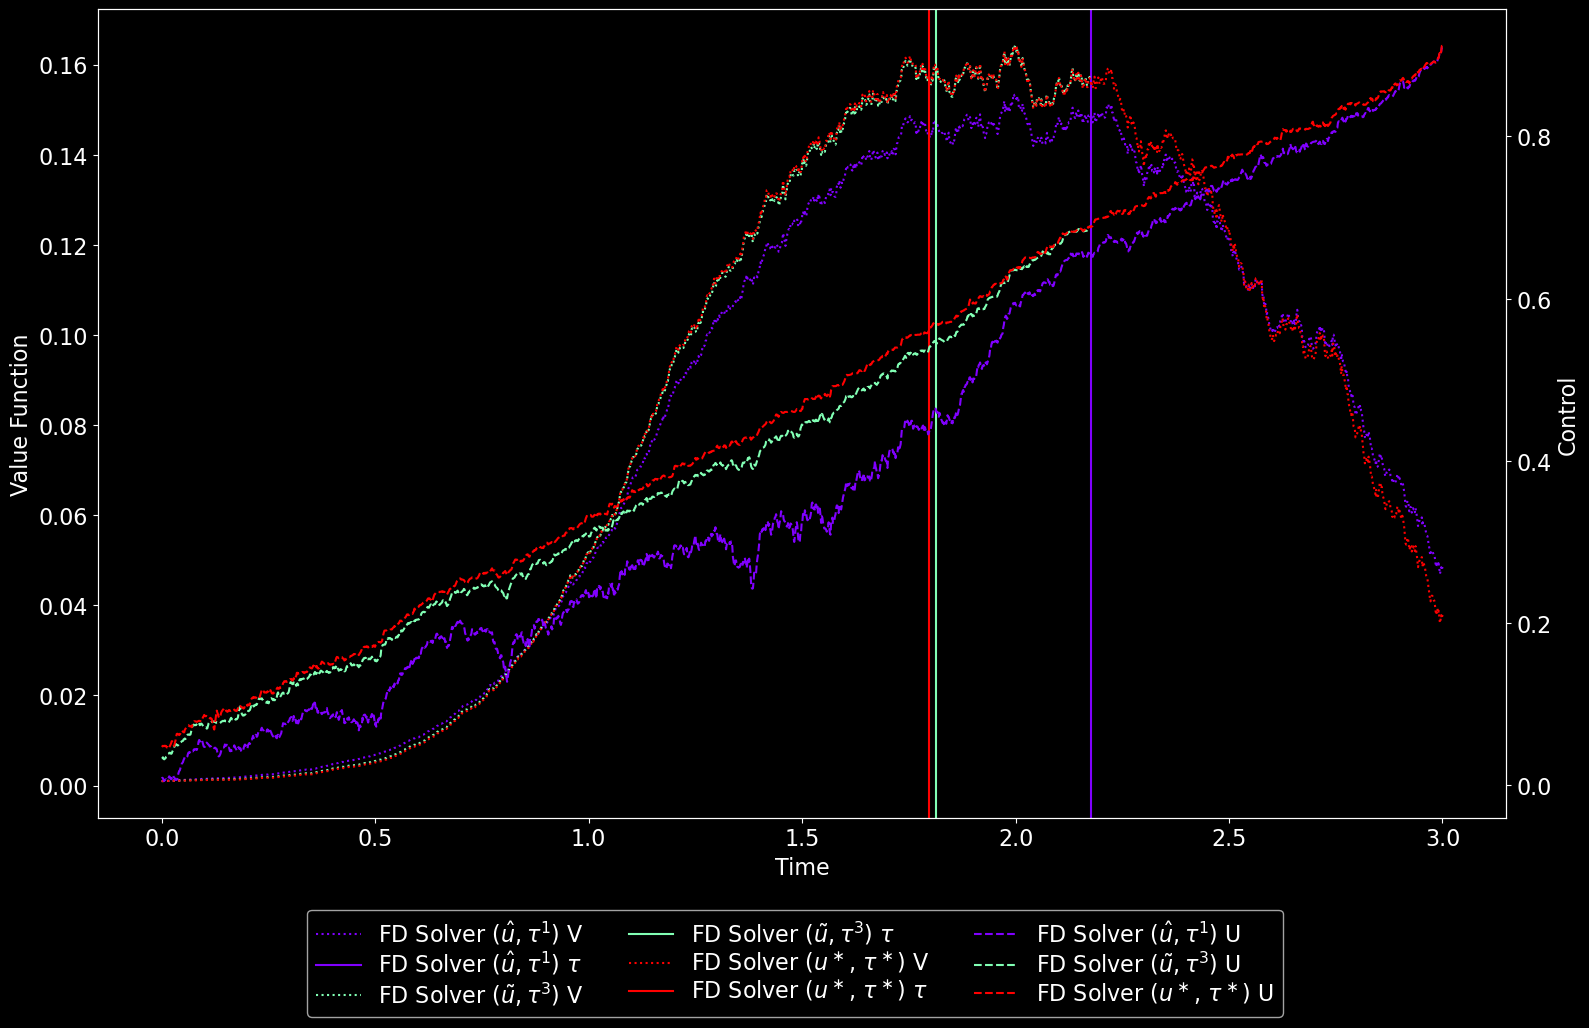

In [14]:
# %%script echo skipping # Disable cell execution
fd3tmp=torch.full_like(fd2.cpu(), torch.nan)
fd3tmp[:,:tauInd_determ.item(),:]=fd3.cpu()
for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        figComp=plotComparison(t, [fd2[:,:,-1],fd3tmp[:,:,-1], fd1[:,:,-1]],
                [fd2[:,:,-2], fd3tmp[:,:,-2], fd1[:,:,-2]],
                [tau_determ*torch.ones_like(tau_fd1.cpu()), tau_fd3.cpu(), tau_fd1.cpu()],
                wi=[0],
                labels=[r"FD Solver ($\hat{u}, \tau^1$)", r"FD Solver ($\tilde{u}, \tau^3$)", r"FD Solver ($u^\ast$, $\tau^\ast$)"])
        figComp.savefig(figureSaveDirectory + "FD_comparison_" + style + ".pdf",bbox_inches='tight')
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

## Deep Solver

100%|██████████| 10000/10000 [04:13<00:00, 39.47it/s, PDE Loss=0.00078, Free BD Loss=9.35e-5, TVP Loss=0.000138, y<=fB=0.5, Ctrl=0.419, LR=[9.765625e-06]] 


Deep Solver (u=u^*) stopped with fuzzy  0.001  at ( 2.8895792961120605 ):  0.1338757574558258
Deep Solver (u=u^*) stopped with fuzzy  0.01  at ( 1.8729619979858398 ):  0.1835693120956421
Deep Solver (u=u^*) stopped with fuzzy  0.1  at ( 1.1544251441955566 ):  0.0916447788476944


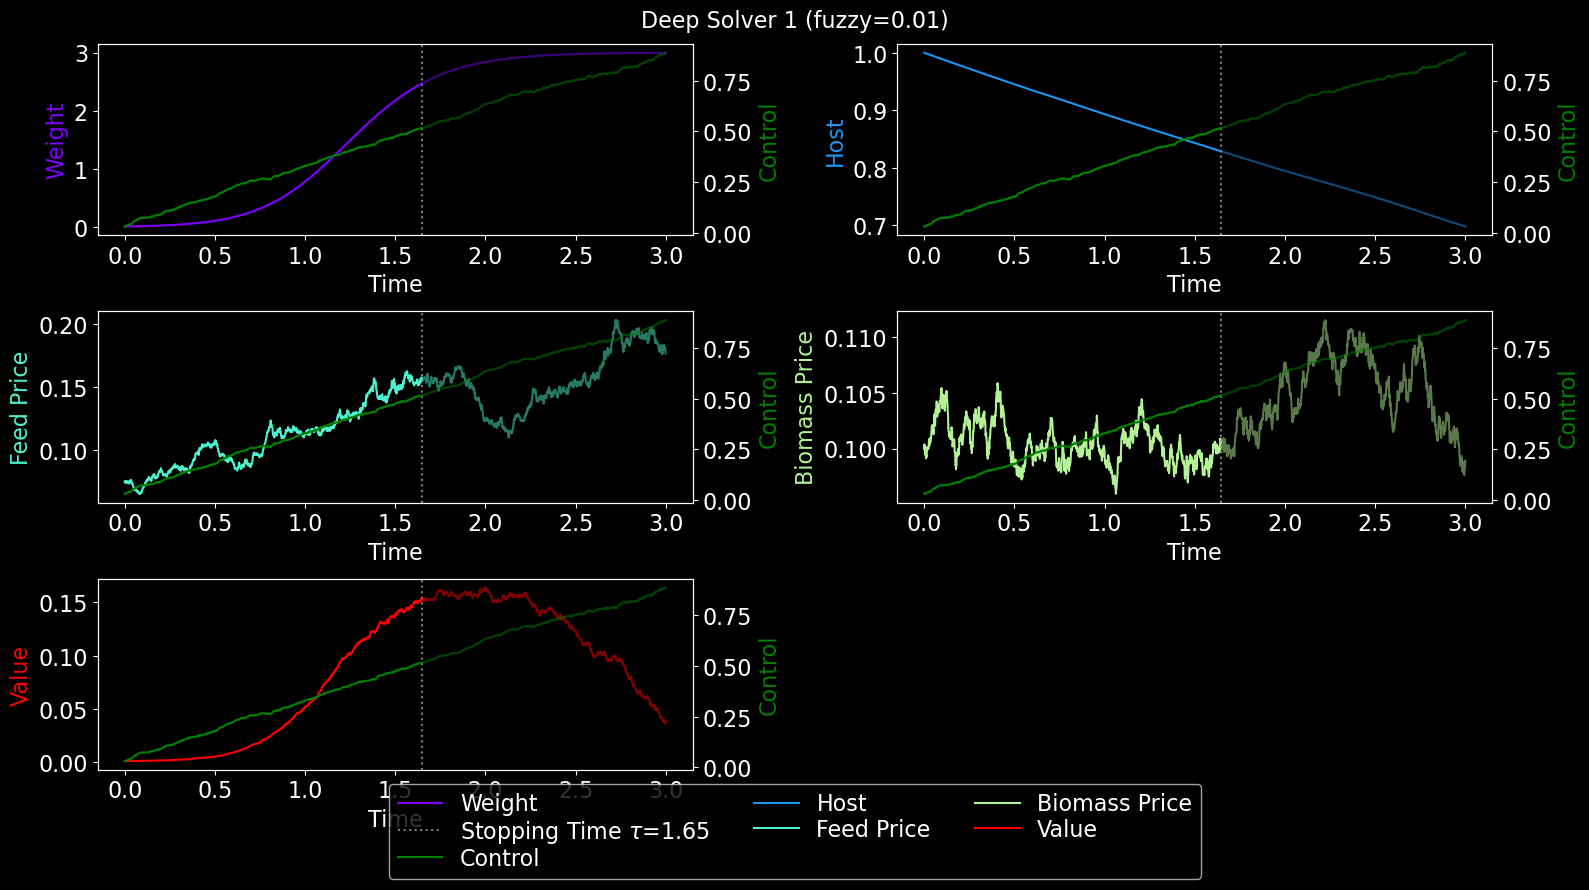

100%|██████████| 1500/1500 [04:19<00:00,  5.79it/s, loss=-0.182, payoff=0.183, learning rate=[0.0005000000000000001]]


Deep Solver 1 (u=û) opt stopped at ( 1.9597325325012207 ): with value 0.18333938717842102 and fd error 0.0007116943597793579


In [15]:
# %%script echo skipping # Disable cell execution
torch.manual_seed(seed+10)
torch.cuda.manual_seed_all(seed+10)
u1 = ControlProcessAquaculture({'f0':f0,'T':T,'w_inf':w_inf,'gamma_F':gamma_F,'mu_F':mu_F}, F)
dgmCell1 = DGMCellFF(input_dim=len(bnds[:-1]), hidden_dim=32, n_layers=3, output_dim=1).to(device).to(dtype)
deepSolverArgs = {'dgmCell': dgmCell1,'u': u1, 'lr': 5e-3}
deepOpt1 = JointOptCtrlStopping(r, k, g, bnds[:-1], processes, DeepSolver, deepSolverArgs, device=device, dtype=dtype)
deepOpt1.solve(epochs=10000,batch_size=4096,stopping=True)
fuzzy = 1e-3
deep1_tmp1, tau_deep1_tmp1, tauInd_deep1_tmp1 = deepOpt1.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep1_tmp1.mean().item(), "): ", torch.mean(torch.take_along_dim(deep1_tmp1[:,:,-1], tauInd_deep1_tmp1.unsqueeze(-1), dim=1)).item())
fuzzy = 1e-2
deep1_tmp2, tau_deep1_tmp2, tauInd_deep1_tmp2 = deepOpt1.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep1_tmp2.mean().item(), "): ", torch.mean(torch.take_along_dim(deep1_tmp2[:,:,-1], tauInd_deep1_tmp2.unsqueeze(-1), dim=1)).item())
fuzzy = 1e-1
deep1_tmp3, tau_deep1_tmp3, tauInd_deep1_tmp3 = deepOpt1.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep1_tmp3.mean().item(), "): ", torch.mean(torch.take_along_dim(deep1_tmp3[:,:,-1], tauInd_deep1_tmp3.unsqueeze(-1), dim=1)).item())
deep1Ind = torch.argmax(torch.tensor([torch.mean(torch.take_along_dim(deep1_tmp1[:,:,-1], tauInd_deep1_tmp1.unsqueeze(-1), dim=1)), torch.mean(torch.take_along_dim(deep1_tmp2[:,:,-1], tauInd_deep1_tmp2.unsqueeze(-1), dim=1)), torch.mean(torch.take_along_dim(deep1_tmp3[:,:,-1], tauInd_deep1_tmp3.unsqueeze(-1), dim=1))])).item()
deep1 = [deep1_tmp1, deep1_tmp2, deep1_tmp3][deep1Ind]
tau_deep1 = [tau_deep1_tmp1, tau_deep1_tmp2, tau_deep1_tmp3][deep1Ind]
tauInd_deep1 = [tauInd_deep1_tmp1, tauInd_deep1_tmp2, tauInd_deep1_tmp3][deep1Ind]

for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_deep1 = plotMethod(t, deep1, tau_deep1, tauInd_deep1, wi=[0], labels=labels,title="Deep Solver 1"+" (fuzzy="+str([1e-3,1e-2,1e-1][deep1Ind])+")")
        fig_deep1.savefig(figureSaveDirectory + "deep1_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

if not Path(fileSaveDirectory + "tau_ds1.npy").is_file():
    N_os:int = int(T*128) # number of time steps, don't use too many, it will slow down the method a lot
    t_os:torch.Tensor = torch.linspace(0.0,T,N_os,dtype=dtype,device=device)

    deepOpt1.V = None
    # deep1, _, _ = deepOpt1.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)
    def trainGen(M,batch_factor=64):
        while True:
            dWt = BrownianMotion(t_os, M * batch_factor, dim=d, onlyIncrements=True, dtype=dtype, device=device)
            data = deepOpt1.simulate(t_os, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)[0]
            for i in range(batch_factor):
                yield data[i*M:(i+1)*M,...]

    latent_dim: List[int] = [d+50,d+50] 
    dOS = DeepOSNet(d+1,N_os,latent_dim=latent_dim,outputDims=1).to(device) #d+1 because control is included
    trainErr, trainPrice=dOS.train_loop(trainGen)
    indOS = torch.argmin(torch.abs(t_os.view(-1,1) - t.view(1,-1)), dim=1)
    tau_ds1,payoff_ds1=dOS.evalStopping(t[:,indOS],deep1[:,indOS,:])
    tauInd_ds1 = torch.min(torch.abs(t-tau_ds1), dim=1, keepdim=False)[1]
    np.save(fileSaveDirectory+"tau_ds1.npy", tau_ds1.cpu().numpy())
    np.save(fileSaveDirectory+"payoff_ds1.npy", payoff_ds1.cpu().numpy())
    np.save(fileSaveDirectory+"tauInd_ds1.npy", tauInd_ds1.cpu().numpy())
    del dOS
else:
    tau_ds1 = torch.from_numpy(np.load(fileSaveDirectory+"tau_ds1.npy")).to(dtype=dtype, device=device)
    payoff_ds1 = torch.from_numpy(np.load(fileSaveDirectory+"payoff_ds1.npy")).to(dtype=dtype, device=device)
    tauInd_ds1 = torch.from_numpy(np.load(fileSaveDirectory+"tauInd_ds1.npy")).to(dtype=torch.int64, device=device)

print(f'Deep Solver 1 (u=û) opt stopped at ( {tau_ds1.mean().item()} ): with value {torch.take_along_dim(deep1[:,:,-1], tauInd_ds1.unsqueeze(-1), dim=1).mean().item()} and fd error {np.abs(torch.take_along_dim(deep1[:,:,-1], tauInd_ds1.unsqueeze(-1), dim=1).mean().item()-torch.take_along_dim(fd1[:,:,-1], tauInd_fd1.unsqueeze(-1), dim=1).mean().item())}')
del deepOpt1, dgmCell1, u1

100%|██████████| 10000/10000 [07:46<00:00, 21.45it/s, PDE Loss=0.00101, Free BD Loss=9.77e-5, TVP Loss=0.00019, y<=fB=0.5, Ctrl=0.423, LR=[9.765625e-06]]  


Deep Solver (u=u^*) stopped with fuzzy  0.001  at ( 3.0 ):  0.12402170896530151
Deep Solver (u=u^*) stopped with fuzzy  0.01  at ( 1.9718151092529297 ):  0.1835324466228485
Deep Solver (u=u^*) stopped with fuzzy  0.1  at ( 1.1939027309417725 ):  0.10016877204179764


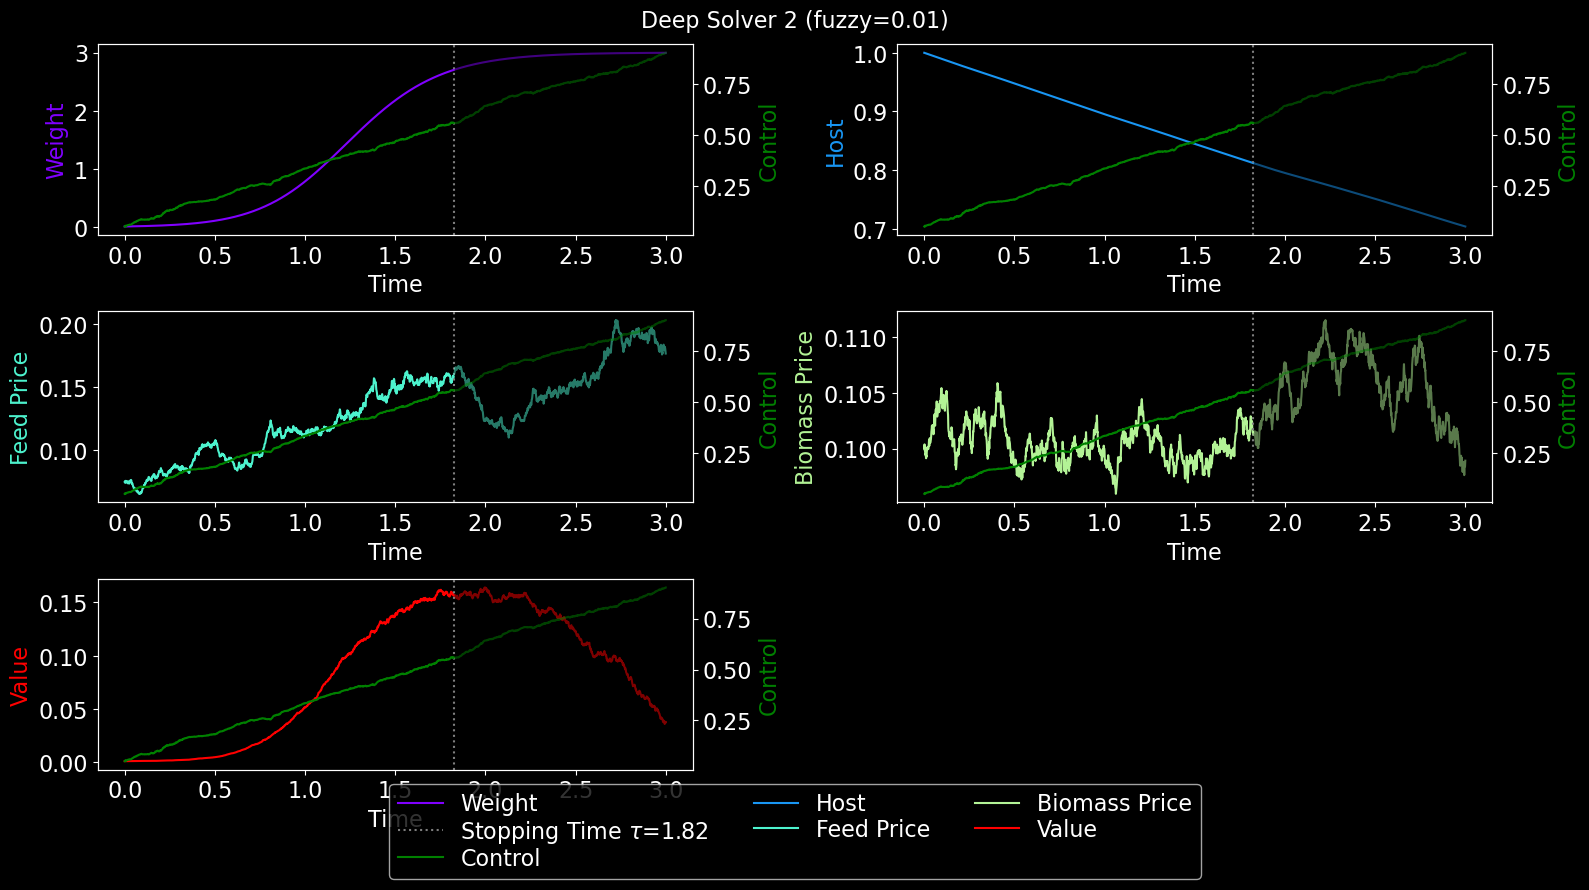

100%|██████████| 1500/1500 [04:16<00:00,  5.84it/s, loss=-0.181, payoff=0.182, learning rate=[0.0005000000000000001]]


Deep Solver 2 (u=û) opt stopped at ( 1.9654829502105713 ): with value 0.18252795934677124 and fd error 0.0015231221914291382


In [16]:
# %%script echo skipping # Disable cell execution
torch.manual_seed(seed+11)
torch.cuda.manual_seed_all(seed+11)
u2 = ControlProcessNN({},input_dim=len(bnds[:-1]), hidden_dim=32, n_layers=3, output_dim=1, lr=1e-2).to(device).to(dtype)
dgmCell2 = DGMCellFF(input_dim=len(bnds[:-1]), hidden_dim=32, n_layers=3, output_dim=1).to(device).to(dtype)
deepSolverArgs = {'dgmCell': dgmCell2,'u': u2, 'lr': 5e-3}
deepOpt2 = JointOptCtrlStopping(r, k, g, bnds[:-1], processes, DeepSolver, deepSolverArgs, device=device, dtype=dtype)
deepOpt2.solve(epochs=10000,batch_size=4096,stopping=True)
fuzzy = 1e-3
deep2_tmp1, tau_deep2_tmp1, tauInd_deep2_tmp1 = deepOpt2.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep2_tmp1.mean().item(), "): ", torch.mean(torch.take_along_dim(deep2_tmp1[:,:,-1], tauInd_deep2_tmp1.unsqueeze(-1), dim=1)).item())
fuzzy = 1e-2
deep2_tmp2, tau_deep2_tmp2, tauInd_deep2_tmp2 = deepOpt2.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep2_tmp2.mean().item(), "): ", torch.mean(torch.take_along_dim(deep2_tmp2[:,:,-1], tauInd_deep2_tmp2.unsqueeze(-1), dim=1)).item())
fuzzy = 1e-1
deep2_tmp3, tau_deep2_tmp3, tauInd_deep2_tmp3 = deepOpt2.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep2_tmp3.mean().item(), "): ", torch.mean(torch.take_along_dim(deep2_tmp3[:,:,-1], tauInd_deep2_tmp3.unsqueeze(-1), dim=1)).item())
deep2Ind = torch.argmax(torch.tensor([torch.mean(torch.take_along_dim(deep2_tmp1[:,:,-1], tauInd_deep2_tmp1.unsqueeze(-1), dim=1)), torch.mean(torch.take_along_dim(deep2_tmp2[:,:,-1], tauInd_deep2_tmp2.unsqueeze(-1), dim=1)), torch.mean(torch.take_along_dim(deep2_tmp3[:,:,-1], tauInd_deep2_tmp3.unsqueeze(-1), dim=1))])).item()
deep2 = [deep2_tmp1, deep2_tmp2, deep2_tmp3][deep2Ind]
tau_deep2 = [tau_deep2_tmp1, tau_deep2_tmp2, tau_deep2_tmp3][deep2Ind]
tauInd_deep2 = [tauInd_deep2_tmp1, tauInd_deep2_tmp2, tauInd_deep2_tmp3][deep2Ind]

for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_deep2 = plotMethod(t, deep2, tau_deep2, tauInd_deep2, wi=[0], labels=labels,title="Deep Solver 2"+" (fuzzy="+str([1e-3,1e-2,1e-1][deep2Ind])+")")
        fig_deep2.savefig(figureSaveDirectory + "deep2_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

if not Path(fileSaveDirectory + "tau_ds2.npy").is_file():
    N_os:int = int(T*128) # number of time steps, don't use too many, it will slow down the method a lot
    t_os:torch.Tensor = torch.linspace(0.0,T,N_os,dtype=dtype,device=device)

    deepOpt2.V = None
    # deep1, _, _ = deepOpt1.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)
    def trainGen(M,batch_factor=64):
        while True:
            dWt = BrownianMotion(t_os, M * batch_factor, dim=d, onlyIncrements=True, dtype=dtype, device=device)
            data = deepOpt2.simulate(t_os, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)[0]
            for i in range(batch_factor):
                yield data[i*M:(i+1)*M,...]

    latent_dim: List[int] = [d+50,d+50] 
    dOS = DeepOSNet(d+1,N_os,latent_dim=latent_dim,outputDims=1).to(device) #d+1 because control is included
    trainErr, trainPrice=dOS.train_loop(trainGen)
    indOS = torch.argmin(torch.abs(t_os.view(-1,1) - t.view(1,-1)), dim=1)
    tau_ds2,payoff_ds2=dOS.evalStopping(t[:,indOS],deep2[:,indOS,:])
    tauInd_ds2 = torch.min(torch.abs(t-tau_ds2), dim=1, keepdim=False)[1]
    np.save(fileSaveDirectory+"tau_ds2.npy", tau_ds2.cpu().numpy())
    np.save(fileSaveDirectory+"payoff_ds2.npy", payoff_ds2.cpu().numpy())
    np.save(fileSaveDirectory+"tauInd_ds2.npy", tauInd_ds2.cpu().numpy())
    del dOS
else:
    tau_ds2 = torch.from_numpy(np.load(fileSaveDirectory+"tau_ds2.npy")).to(dtype=dtype, device=device)
    payoff_ds2 = torch.from_numpy(np.load(fileSaveDirectory+"payoff_ds2.npy")).to(dtype=dtype, device=device)
    tauInd_ds2 = torch.from_numpy(np.load(fileSaveDirectory+"tauInd_ds2.npy")).to(dtype=torch.int64, device=device)

print(f'Deep Solver 2 (u=û) opt stopped at ( {tau_ds2.mean().item()} ): with value {torch.take_along_dim(deep2[:,:,-1], tauInd_ds2.unsqueeze(-1), dim=1).mean().item()} and fd error {np.abs(torch.take_along_dim(deep2[:,:,-1], tauInd_ds2.unsqueeze(-1), dim=1).mean().item()-torch.take_along_dim(fd1[:,:,-1], tauInd_fd1.unsqueeze(-1), dim=1).mean().item())}')
del deepOpt2, dgmCell2, u2

In [17]:
tau_ds2 = torch.from_numpy(np.load(fileSaveDirectory+"tau_ds2.npy")).to(dtype=dtype, device=device)
payoff_ds2 = torch.from_numpy(np.load(fileSaveDirectory+"payoff_ds2.npy")).to(dtype=dtype, device=device)
tauInd_ds2 = torch.from_numpy(np.load(fileSaveDirectory+"tauInd_ds2.npy")).to(dtype=torch.int64, device=device)
print(f'Deep Solver 2 (u=û) opt stopped at ( {tau_ds2.mean().item()} ): with value {torch.take_along_dim(deep2[:,:,-1], tauInd_ds2.unsqueeze(-1), dim=1).mean().item()} and fd error {np.abs(torch.take_along_dim(deep2[:,:,-1], tauInd_ds2.unsqueeze(-1), dim=1).mean().item()-torch.take_along_dim(fd1[:,:,-1], tauInd_fd1.unsqueeze(-1), dim=1).mean().item())}')

Deep Solver 2 (u=û) opt stopped at ( 1.9654829502105713 ): with value 0.18252795934677124 and fd error 0.0015231221914291382


100%|██████████| 10000/10000 [08:24<00:00, 19.83it/s, PDE Loss=0.0012, Free BD Loss=0.00012, TVP Loss=0.000207, y<=fB=0.5, Ctrl=0.427, LR=[9.765625e-06]]  


Deep Solver (u=u^*) stopped with fuzzy  0.001  at ( 2.999305486679077 ):  0.12412328273057938
Deep Solver (u=u^*) stopped with fuzzy  0.01  at ( 2.1604981422424316 ):  0.17849452793598175
Deep Solver (u=u^*) stopped with fuzzy  0.1  at ( 1.1962206363677979 ):  0.10064471513032913


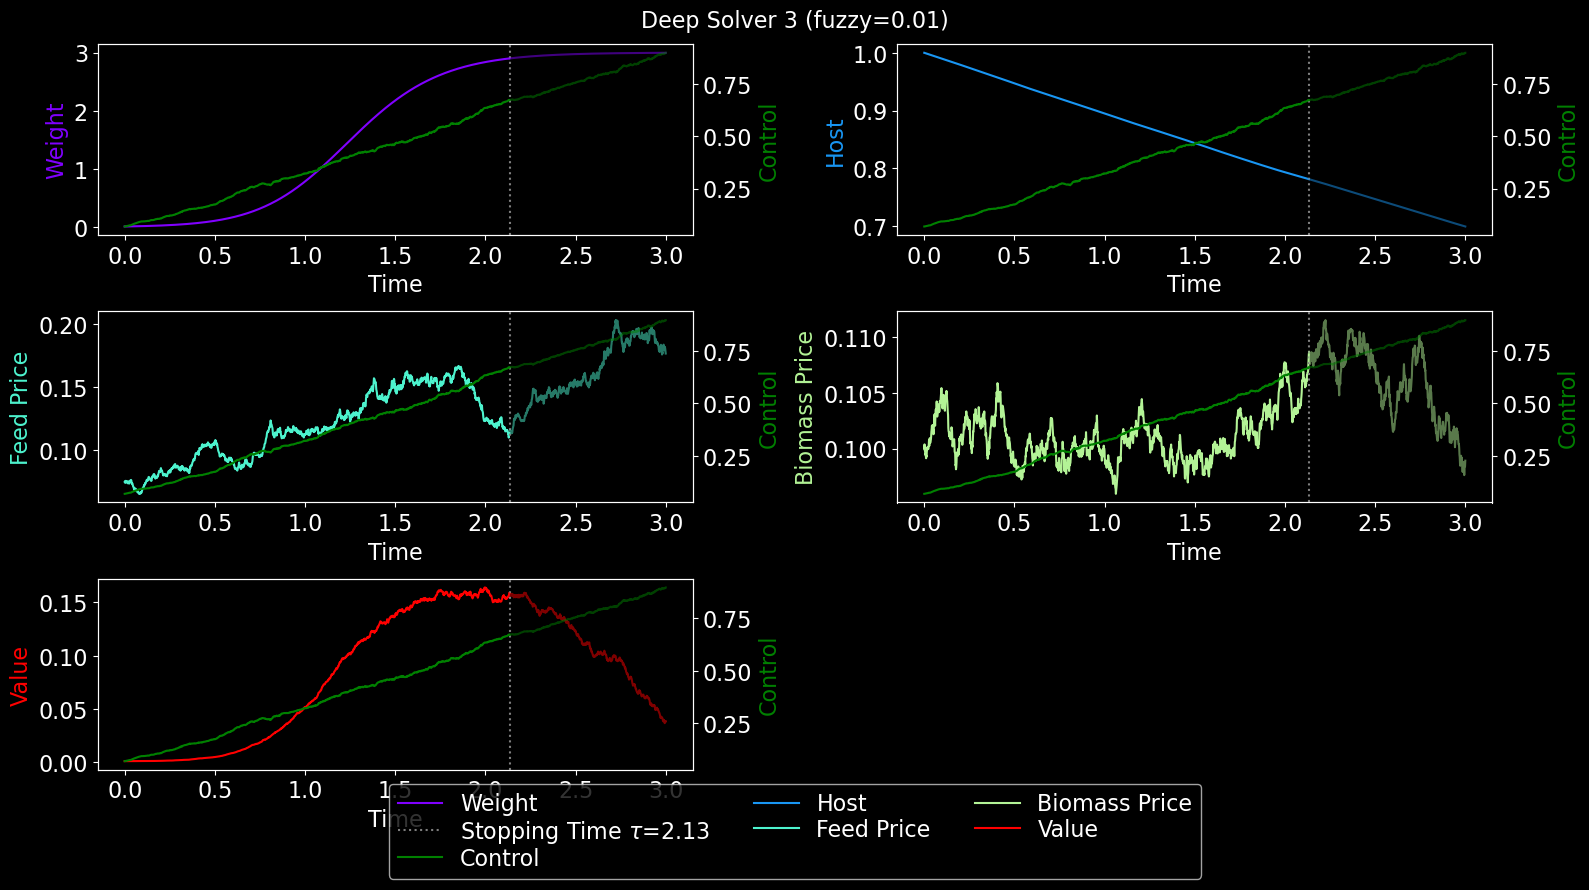

100%|██████████| 1500/1500 [04:14<00:00,  5.89it/s, loss=-0.182, payoff=0.182, learning rate=[0.0005000000000000001]]


Deep Solver 3 (u=û) opt stopped at ( 1.9640140533447266 ): with value 0.18293669819831848 and fd error 0.001114383339881897


In [18]:
# %%script echo skipping # Disable cell execution
torch.manual_seed(seed+13)
torch.cuda.manual_seed_all(seed+13)
u3 = ControlProcessNN2({},input_dim=len(bnds[:-1]), hidden_dim=32, n_layers=3, output_dim=1, lr=1e-2).to(device).to(dtype)
dgmCell3 = DGMCellFF(input_dim=len(bnds[:-1]), hidden_dim=32, n_layers=3, output_dim=1).to(device).to(dtype)
deepSolverArgs = {'dgmCell': dgmCell3,'u': u3, 'lr': 5e-3}
deepOpt3 = JointOptCtrlStopping(r, k, g, bnds[:-1], processes, DeepSolver, deepSolverArgs, device=device, dtype=dtype)
deepOpt3.solve(epochs=10000,batch_size=4096,stopping=True)
fuzzy = 1e-3
deep3_tmp1, tau_deep3_tmp1, tauInd_deep3_tmp1 = deepOpt3.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep3_tmp1.mean().item(), "): ", torch.mean(torch.take_along_dim(deep3_tmp1[:,:,-1], tauInd_deep3_tmp1.unsqueeze(-1), dim=1)).item())
fuzzy = 1e-2
deep3_tmp2, tau_deep3_tmp2, tauInd_deep3_tmp2 = deepOpt3.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep3_tmp2.mean().item(), "): ", torch.mean(torch.take_along_dim(deep3_tmp2[:,:,-1], tauInd_deep3_tmp2.unsqueeze(-1), dim=1)).item())
fuzzy = 1e-1
deep3_tmp3, tau_deep3_tmp3, tauInd_deep3_tmp3 = deepOpt3.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep3_tmp3.mean().item(), "): ", torch.mean(torch.take_along_dim(deep3_tmp3[:,:,-1], tauInd_deep3_tmp3.unsqueeze(-1), dim=1)).item())
deep3Ind = torch.argmax(torch.tensor([torch.mean(torch.take_along_dim(deep3_tmp1[:,:,-1], tauInd_deep3_tmp1.unsqueeze(-1), dim=1)), torch.mean(torch.take_along_dim(deep3_tmp2[:,:,-1], tauInd_deep3_tmp2.unsqueeze(-1), dim=1)), torch.mean(torch.take_along_dim(deep3_tmp3[:,:,-1], tauInd_deep3_tmp3.unsqueeze(-1), dim=1))])).item()
deep3 = [deep3_tmp1, deep3_tmp2, deep3_tmp3][deep3Ind]
tau_deep3 = [tau_deep3_tmp1, tau_deep3_tmp2, tau_deep3_tmp3][deep3Ind]
tauInd_deep3 = [tauInd_deep3_tmp1, tauInd_deep3_tmp2, tauInd_deep3_tmp3][deep3Ind]

for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_deep3 = plotMethod(t, deep3, tau_deep3, tauInd_deep3, wi=[0], labels=labels,title="Deep Solver 3"+" (fuzzy="+str([1e-3,1e-2,1e-1][deep3Ind])+")")
        fig_deep3.savefig(figureSaveDirectory + "deep3_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

if not Path(fileSaveDirectory + "tau_ds3.npy").is_file():
    N_os:int = int(T*128) # number of time steps, don't use too many, it will slow down the method a lot
    t_os:torch.Tensor = torch.linspace(0.0,T,N_os,dtype=dtype,device=device)

    deepOpt3.V = None
    # deep1, _, _ = deepOpt1.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)
    def trainGen(M,batch_factor=64):
        while True:
            dWt = BrownianMotion(t_os, M * batch_factor, dim=d, onlyIncrements=True, dtype=dtype, device=device)
            data = deepOpt3.simulate(t_os, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)[0]
            for i in range(batch_factor):
                yield data[i*M:(i+1)*M,...]

    latent_dim: List[int] = [d+50,d+50] 
    dOS = DeepOSNet(d+1,N_os,latent_dim=latent_dim,outputDims=1).to(device) #d+1 because control is included
    trainErr, trainPrice=dOS.train_loop(trainGen)
    indOS = torch.argmin(torch.abs(t_os.view(-1,1) - t.view(1,-1)), dim=1)
    tau_ds3,payoff_ds3=dOS.evalStopping(t[:,indOS],deep3[:,indOS,:])
    tauInd_ds3 = torch.min(torch.abs(t-tau_ds3), dim=1, keepdim=False)[1]
    np.save(fileSaveDirectory+"tau_ds3.npy", tau_ds3.cpu().numpy())
    np.save(fileSaveDirectory+"payoff_ds3.npy", payoff_ds3.cpu().numpy())
    np.save(fileSaveDirectory+"tauInd_ds3.npy", tauInd_ds3.cpu().numpy())
    del dOS
else:
    tau_ds3 = torch.from_numpy(np.load(fileSaveDirectory+"tau_ds3.npy")).to(dtype=dtype, device=device)
    payoff_ds3 = torch.from_numpy(np.load(fileSaveDirectory+"payoff_ds3.npy")).to(dtype=dtype, device=device)
    tauInd_ds3 = torch.from_numpy(np.load(fileSaveDirectory+"tauInd_ds3.npy")).to(dtype=torch.int64, device=device)

print(f'Deep Solver 3 (u=û) opt stopped at ( {tau_ds3.mean().item()} ): with value {torch.take_along_dim(deep3[:,:,-1], tauInd_ds3.unsqueeze(-1), dim=1).mean().item()} and fd error {np.abs(torch.take_along_dim(deep3[:,:,-1], tauInd_ds3.unsqueeze(-1), dim=1).mean().item()-torch.take_along_dim(fd1[:,:,-1], tauInd_fd1.unsqueeze(-1), dim=1).mean().item())}')
del deepOpt3, dgmCell3, u3

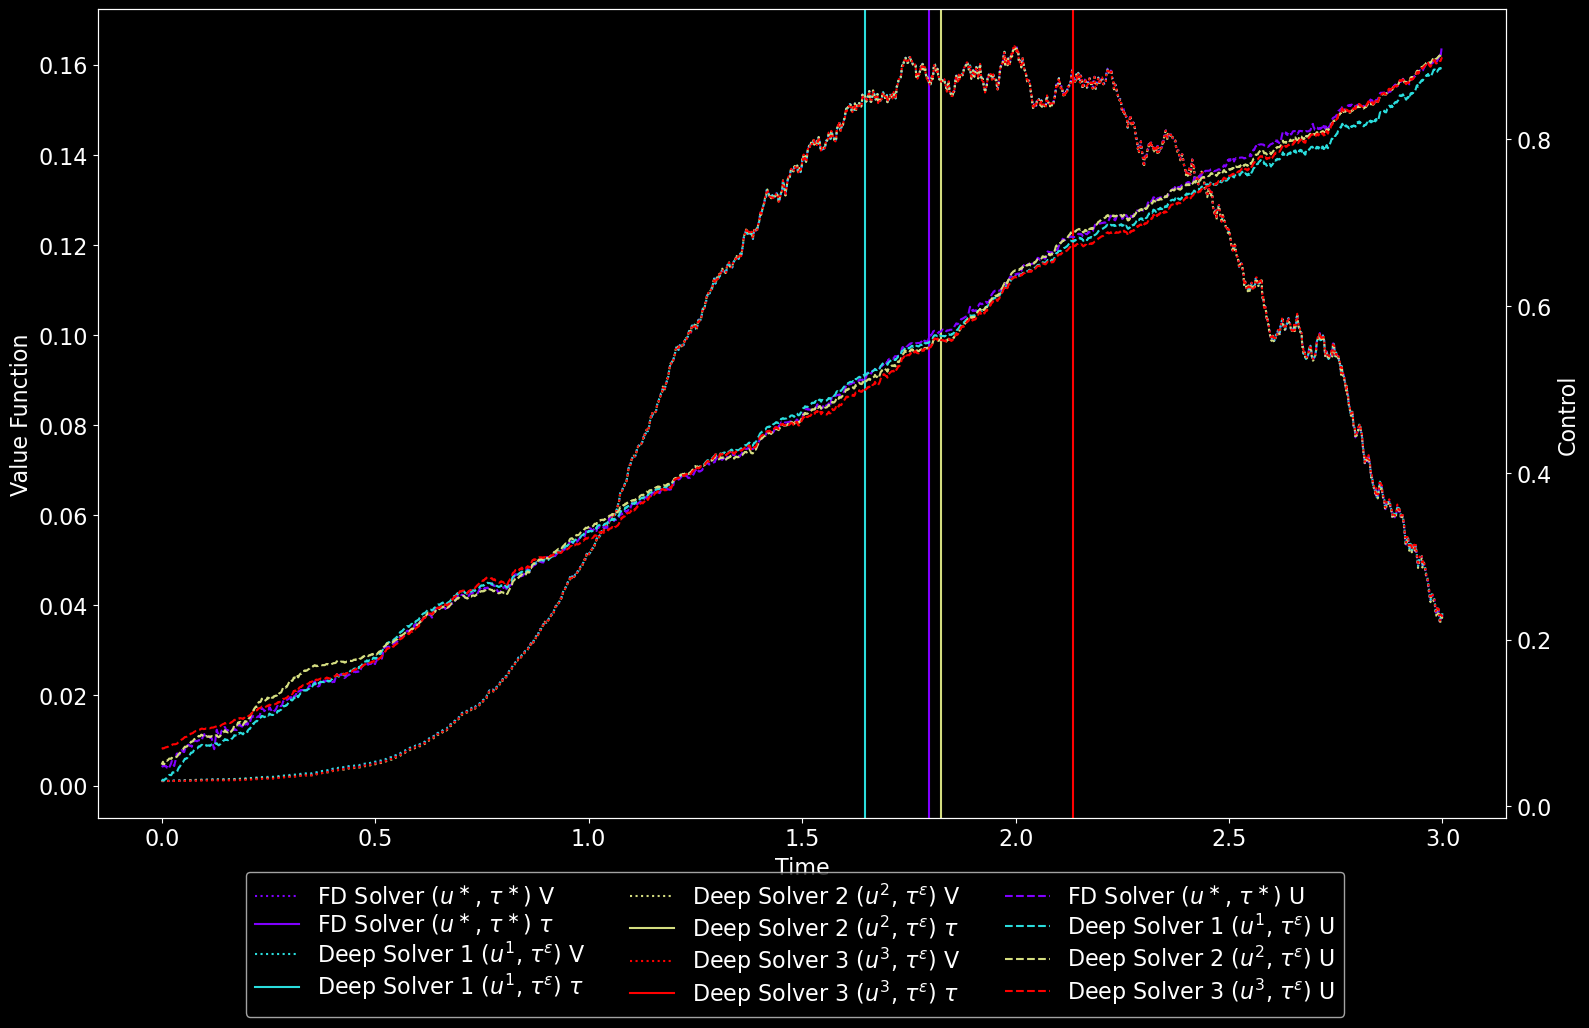

In [19]:
for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        figComp=plotComparison(t, [fd1[:,:,-1], deep1[:,:,-1], deep2[:,:,-1], deep3[:,:,-1]],
                [fd1[:,:,-2], deep1[:,:,-2], deep2[:,:,-2], deep3[:,:,-2]],
                [tau_fd1.cpu(), tau_deep1.cpu(), tau_deep2.cpu(), tau_deep3.cpu()],
                wi=[0],
                labels=[r"FD Solver ($u^\ast$, $\tau^\ast$)", r"Deep Solver 1 ($u^1$, $\tau^\varepsilon$)", r"Deep Solver 2 ($u^2$, $\tau^\varepsilon$)", r"Deep Solver 3 ($u^3$, $\tau^\varepsilon$)"])
        figComp.savefig(figureSaveDirectory + "DS_comparison_" + style + ".pdf",bbox_inches='tight')
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

In [20]:
def add_row(df, method, no_os, os, tau):
    improvement = (os / no_os - 1) * 100 if no_os != 0 else None
    return pd.concat([df, pd.DataFrame([[method, no_os/1.0, os/1.0, tau/1.0, improvement/1.0]], columns=df.columns)], ignore_index=True)
    

                                   Method  No OS     OS  $\tau$  Improvement
          Benchmark ($u=0$, $\tau$ const) 0.0010 0.0285  2.1764    2843.1393
          Benchmark ($u=F$, $\tau$ const) 0.1175 0.1732  2.1764      47.3275
     FD Solver ($u=u^\ast$, $\tau$ const) 0.1259 0.1761  2.1764      39.8374
    FD Solver ($u=u^\ast$ \& $\tau^\ast$)    NaN 0.1841  1.9652          NaN
Deep Solver 1 ($u=u^\ast$ \& $\tau^\ast$)    NaN 0.1836  1.9597          NaN
Deep Solver 2 ($u=u^\ast$ \& $\tau^\ast$)    NaN 0.1825  1.9655          NaN
Deep Solver 3 ($u=u^\ast$ \& $\tau^\ast$)    NaN 0.1829  1.9640          NaN


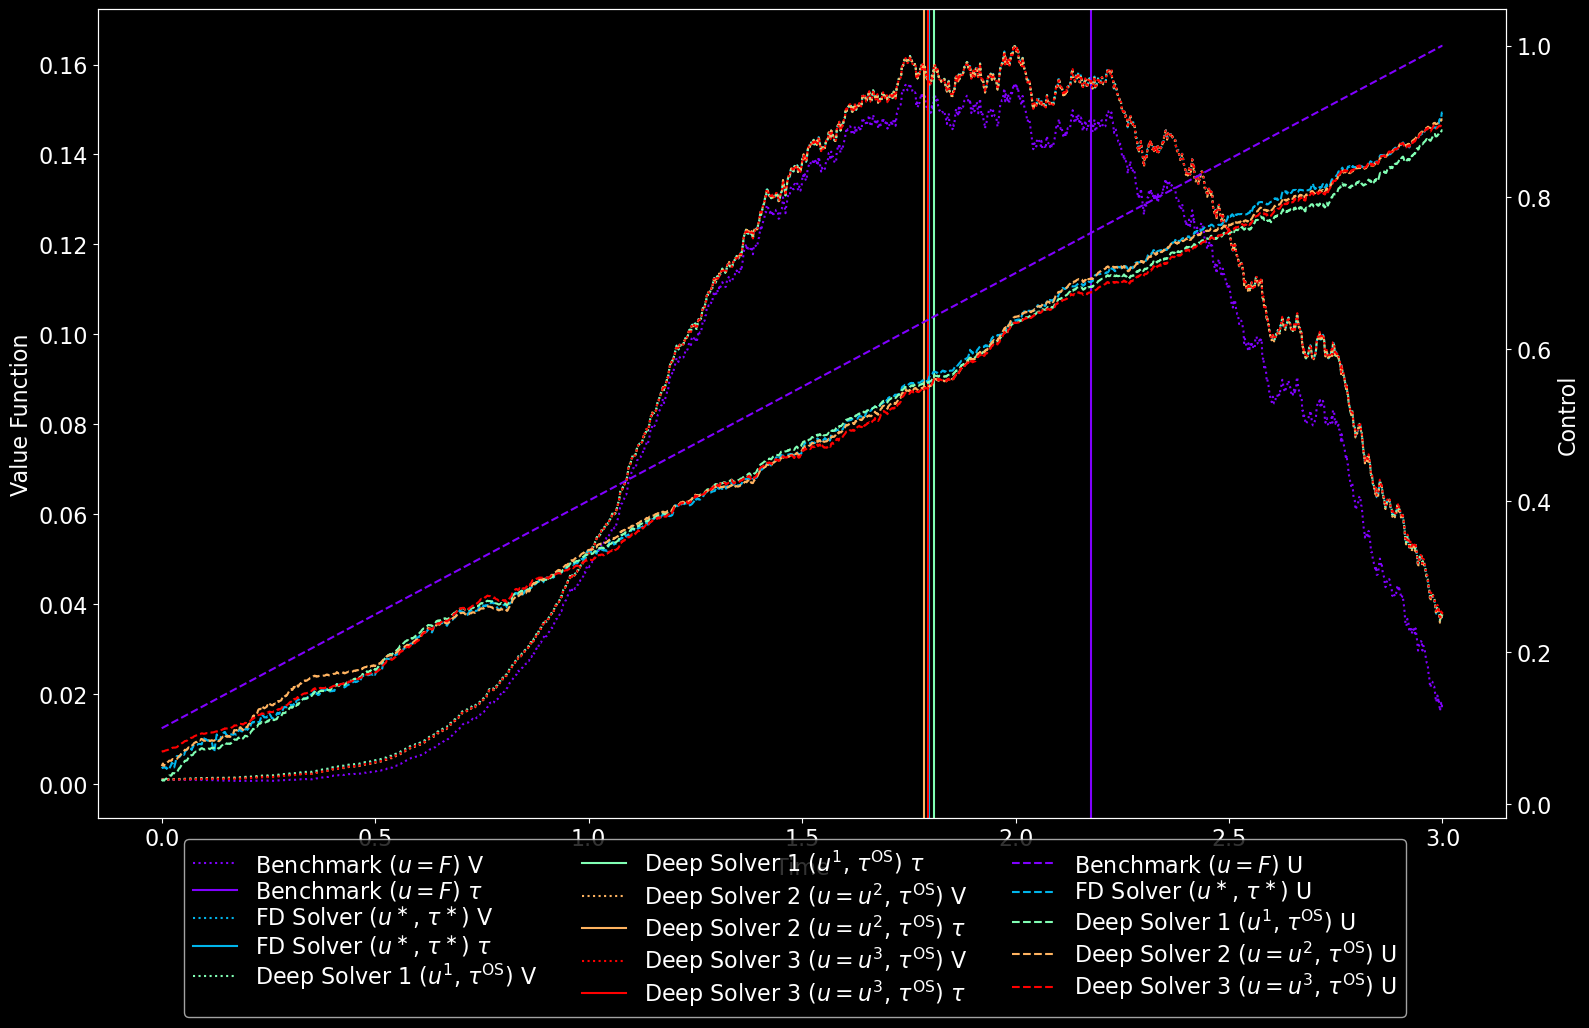

In [21]:
# Results
df = pd.DataFrame(columns=["Method", "No OS", "OS", r"$\tau$", "Improvement"])
df = add_row(df, r"Benchmark ($u=0$, $\tau$ const)", torch.mean(bench_0[:,-1,-1]).item(), torch.mean(bench_0[:,tauInd_determ,-1]).item(), tau_determ.item())
df = add_row(df, r"Benchmark ($u=F$, $\tau$ const)", torch.mean(bench_ft[:,-1,-1]).item(), torch.mean(bench_ft[:,tauInd_determ,-1]).item(), tau_determ.item())
# df = add_row(df, r"Benchmark ($u=F$, $\tau$ DOS)", torch.mean(bench_ft[:,-1,-1]).item(), torch.mean(bench_ft[:,tauInd_determ,-1]).item(), tau_determ.item()) #TODO
df = add_row(df, r"FD Solver ($u=u^\ast$, $\tau$ const)", torch.mean(fd2[:,-1,-1]).item(), torch.mean(fd2[:,tauInd_determ,-1]).item(), tau_determ.item())
# df = add_row(df, r"FD Solver ($u=u^\ast$, $\tau$ DOS)", torch.mean(fd2[:,-1,-1]).item(), torch.mean(fd2[:,tauInd_determ,-1]).item(), tau_determ.item()) #TODO
df = add_row(df, r"FD Solver ($u=u^\ast$ \& $\tau^\ast$)", np.nan, torch.mean(torch.take_along_dim(fd1[:,:,-1], tauInd_fd1.unsqueeze(-1), dim=1)).item(), tau_fd1.mean().item())
df = add_row(df, r"Deep Solver 1 ($u=u^\ast$ \& $\tau^\ast$)", np.nan, torch.mean(torch.take_along_dim(deep1[:,:,-1], tauInd_deep1.unsqueeze(-1), dim=1)).item(), tau_ds1.mean().item())
df = add_row(df, r"Deep Solver 2 ($u=u^\ast$ \& $\tau^\ast$)", np.nan, torch.mean(torch.take_along_dim(deep2[:,:,-1], tauInd_ds2.unsqueeze(-1), dim=1)).item(), tau_ds2.mean().item())
df = add_row(df, r"Deep Solver 3 ($u=u^\ast$ \& $\tau^\ast$)", np.nan, torch.mean(torch.take_along_dim(deep3[:,:,-1], tauInd_ds3.unsqueeze(-1), dim=1)).item(), tau_ds3.mean().item())

print(df.to_string(index=False, float_format="%.4f".__mod__))
# print(df.to_latex(index=False, float_format="%.2f".__mod__, escape=False))
for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        figComp=plotComparison(t, [bench_ft[:,:,-1], fd1[:,:,-1], deep1[:,:,-1], deep2[:,:,-1], deep3[:,:,-1]],
                [bench_ft[:,:,-2], fd1[:,:,-2], deep1[:,:,-2], deep2[:,:,-2], deep3[:,:,-2]],
                [tau_determ*torch.ones_like(tau_fd1.cpu()), tau_fd1.cpu(), tau_ds1.cpu(), tau_ds2.cpu(), tau_ds3.cpu()],
                wi=[0],
                labels=[r"Benchmark ($u=F$)", r"FD Solver ($u^\ast$, $\tau^\ast$)", r"Deep Solver 1 ($u^1$, $\tau^\text{OS}$)", r"Deep Solver 2 ($u=u^2$, $\tau^\text{OS}$)", r"Deep Solver 3 ($u=u^3$, $\tau^\text{OS}$)"])
        figComp.savefig(figureSaveDirectory + "comparison_" + style + ".pdf",bbox_inches='tight')
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()